In [1]:
library(dplyr)
library(DESeq2)
library(biomaRt)
library(RColorBrewer)
library(pheatmap)
library(ggplot2)
library(ggrepel)
library(DT)
library(scales)
library(stringr)
library(grid)
library(Biobase)
library(RColorBrewer)
library(colorspace)
library(EnhancedVolcano)
library(LSD)
library(graphics)
library(viridis)
library(M3C)
library(Rtsne)
library(gplots)
library(readxl)
library(VennDiagram)
library(pals)
library(gprofiler2)
library(openxlsx)
library(ggvenn)
library(tidyr)
library(data.table)
library(purrr)
library(ggpubr)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching 

In [1]:
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
setwd("~/LEO_RNA_Seq/merged/")

In [3]:
#load("../deseq2.dds.RData")
load("../merged/RNA_seq.RData")
dds

class: DESeqDataSet 
dim: 28191 12 
metadata(1): version
assays(4): counts mu H cooks
rownames(28191): 5_8S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(12): EV_1 EV_2 ... RAB5_2 RAB5_3
colData names(3): sampletype samplename sizeFactor

In [4]:
raw <- counts(dds, normalized=FALSE) %>% as.data.frame()
head(raw)

,EV_1,EV_2,EV_3,MIX_1.4_1,MIX_1.4_2,MIX_1.4_3,MIX_4.1_1,MIX_4.1_2,MIX_4.1_3,RAB5_1,RAB5_2,RAB5_3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
5_8S_rRNA,0,3,0,21,0,0,10,0,19,21,4,7
7SK,0,126,27,34,2,32,188,5,284,77,81,3
A1BG,0,15,40,30,220,40,25,45,80,25,25,15
A1BG-AS1,243,405,414,558,774,594,522,819,756,540,450,612
A1CF,0,24,88,24,16,32,48,48,176,8,32,40
A2M,264,288,0,48,612,60,24,132,24,840,96,324


# Metadata

In [5]:
sampleinfo <- data.frame(sampletype = rep(c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"), 1, each = 3),
                         samplename = rep(c(1, 2, 3), 4, each = 1),
                         row.names = colnames(raw_anno_aggr))
sampleinfo

,sampletype,samplename
,<chr>,<dbl>
EV_1,EV,1
EV_2,EV,2
EV_3,EV,3
MIX_1.4_1,MIX_1_4,1
MIX_1.4_2,MIX_1_4,2
MIX_1.4_3,MIX_1_4,3
MIX_4.1_1,MIX_4_1,1
MIX_4.1_2,MIX_4_1,2
MIX_4.1_3,MIX_4_1,3


# Make DESeq2 Object

In [6]:
raw_anno_aggr <- raw_anno_aggr[rowSums(raw_anno_aggr)> 0,]

dds <- DESeqDataSetFromMatrix(countData = raw_anno_aggr,
                              colData = sampleinfo,
                              design = ~ sampletype)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


removing rows of the DESeqDataSet that have no counts, or only a single count across all samples. 

In [7]:
dds <- dds[ rowSums(counts(dds)) > 1, ]

# compute size factor and normalize raw readcounts
now let's obtain the table of normalized raw data and write it down to disk.
Please note that in DESeq2 the "normalized"data isn't actually stored anywhere: the only thing that is stored are the factors one can use to normalize the raw count data if required.

In [8]:
# now let's obtain the table of normalized raw data and write it down to disk
# Please note that in DESeq2 the "normalized"data isn't actually stored anywhere: the only thing that is stored are the factors one can use to normalize the raw count data if required.
# compute size factor and normalize raw readcounts
dds <-  estimateSizeFactors(dds)
readcounts_norm <- as.data.frame(counts(dds, normalized = TRUE))
readcounts_norm$Gene_name <- rownames(readcounts_norm)
sizeFactors(dds)

EV_1      EV_2      EV_3 MIX_1.4_1 MIX_1.4_2 MIX_1.4_3 MIX_4.1_1 MIX_4.1_2 
0.5054578 0.9463574 0.6354792 1.2390182 1.1356527 1.1670289 1.1195911 1.2684382 
MIX_4.1_3    RAB5_1    RAB5_2    RAB5_3 
1.3409834 1.0809617 0.8760491 1.1983969

# Transformations

In [9]:
# transformations
vsd <- vst(dds, blind=F)
rld <- rlog(dds, blind=T)

# Sample to sample distance

In [ ]:
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- rownames(sampleDistMatrix)
colnames(sampleDistMatrix) <- rownames(sampleDistMatrix)

In [ ]:
suppressMessages(library(stringr))

metadata = data.frame(samples = rep(c("1", "2", "3"), 4, each = 1),
                      condition = rep(c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"), 1, each = 3),
                      row.names = colnames(dds),
                      stringsAsFactors = T)

suppressMessages(library(RColorBrewer))

annotation_column <- metadata[,1:(dim(metadata)[2])]
mycolors_s <- polychrome(3); names(mycolors_s) = levels(annotation_column$samples)
mycolors_c <- kelly(22)[3:6]; names(mycolors_c) = levels(annotation_column$condition)


ann_colors = list(samples = mycolors_s, condition=mycolors_c)
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

In [ ]:
sample_distace_plot <- pheatmap(sampleDistMatrix,
                                clustering_distance_rows=sampleDists,
                                clustering_distance_cols=sampleDists, border_color = "white",
                                col=colors, cellwidth = 20, cellheight = 20, annotation_col = annotation_column,
                                annotation_colors = ann_colors, filename = "S_distance.png", 
                                main = "sample to sample distance") 

# PCA

In [ ]:
pca <- pca(readcounts_norm[1:12], labels = rep(c(1, 2, 3), 4, each = 1),  
           legendtitle = "Conditions", axistextsize = 18, 
           legendtextsize = 14, dotsize = 5,
           textlabelsize = 4, colvec =  mycolors_c)

In [ ]:
ggplot(pca$data, aes(x=pca$data$PC1, y=pca$data$PC2, color=as.factor(annotation_column$condition), label = annotation_column$sample))+
  geom_point(size = 7) +
  guides(color = guide_legend(title = "")) +  
  geom_text(data = pca$data, aes(label = annotation_column$sample, color="black"), position = position_dodge(width=1),  size=7, hjust = 2)+
  theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
        axis.text.x = element_text(angle = 90, face = "bold", color = "black", size=22, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 24),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
        axis.title.y = element_text(face = "bold", color = "black", size = 24),
        legend.text = element_text(face = "bold", color = "black", size = 15),
        legend.position="top",
        panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
  xlab(paste(pca$labels$x)) + ylab(paste(pca$labels$y))+ 
  scale_color_manual(values=mycolors_c)+
  ggtitle("")
ggsave("pca.png", dpi = 330, scale = 0.8, width = 10, height = 9)
dev.off()

# t-SNE

In [ ]:
set.seed(1)
tsne_results <- Rtsne(t(readcounts_norm[1:12]), perplexity=3, check_duplicates = FALSE)
embedding <- as.data.frame(tsne_results$Y)

ggplot(embedding, aes(x=V1, y=V2, color=as.factor(annotation_column$condition), label = as.character(annotation_column$samples))) +
  geom_point(size = 7) +
  guides(color = guide_legend(title = "")) +  
  geom_text(data = embedding, aes(label = annotation_column$sample, color="black"), position = position_dodge(width=1),  size=7, hjust = 2)+
  theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
        axis.text.x = element_text(angle = 90, face = "bold", color = "black", size=22, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 24),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=22),
        axis.title.y = element_text(face = "bold", color = "black", size = 24),
        legend.text = element_text(face = "bold", color = "black", size = 15),
        legend.position="top",
        panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
  xlab("t-SNE dimension 1") + ylab("t-SNE dimension 2")+
  guides(fill=guide_legend(title="t-SNE"))+
  scale_color_manual(values=mycolors_c)

ggsave("tsne.png", dpi = 330, scale = 1, width = 10, height = 9)
dev.off()

# Counts distribution

In [ ]:
box_colors <- rep(mycolors_c, time=1, each=3)
epsilon <- 1
png("Count.png",
    width     = 8,
    height    = 4,
    units     = "in",
    res       = 1200)
par(mar=c(5, 7 ,5, 5))
boxplot(log2(readcounts_norm[1:12] + epsilon), col=box_colors, pch=".", 
        horizontal=TRUE, cex.axis=0.7,
        las=1, ylab="", xlab="log2(Counts)")
dev.off()

# Call comparisons

In [10]:
to_write <- list(normalized_counts=readcounts_norm)

dds <- DESeq(dds, parallel = F)
## define contrasts (careful here!!) Control FIB
comparisons <- list(c("MIX_1_4", "EV"),
                 c("MIX_4_1", "EV"),
                 c("RAB5A", "EV"), 
                  c("MIX_1_4", "MIX_4_1"))
res <- list()

for (i in 1:4) {
  contrast=comparisons[[i]] # ratio numerator/denumerator is expressed always as c("numerator", "denumerator")
  phenoData<- colData(dds)
  phenoData<-phenoData[phenoData$sampletype %in% contrast,]
  contast_samples_ordered=rownames(phenoData[order(phenoData$sampletype),])
  fcT=1
  fdr=0.05
  res[[i]] <- results(dds, contrast=c("sampletype",contrast), alpha = fdr, pAdjustMethod="BH", parallel = F)
  names(res)[i] <- as.character(paste(comparisons[[i]][1], "vs", comparisons[[i]][2], sep = "_"))
  
}

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



put summary of contrast in files

In [11]:
for (i in 1:4) {
  sink(paste("res_Contrast_", names(res)[i],".txt", sep = ""))
  summary(res[[i]])
  sink() 
}

In [ ]:
DEGs <- list()

for (i in names(res)) {
  DEGs[[i]] <- res[[i]] %>%
    as.data.frame() %>%
    filter(padj < 0.05) %>%
    tibble::rownames_to_column("Gene_name") %>%
    left_join(., readcounts_norm) %>%
    arrange(log2FoldChange)
}

In [ ]:
openxlsx::write.xlsx(c(to_write, DEGs), "RNA_seq.xlsx", overwrite = T)

In [ ]:
for (i in names(res)) {
  EnhancedVolcano(as.data.frame(res[[i]]),
                  max.overlaps=70,
                  lab = rownames(res[[i]]),
                  y = 'padj', boxedLabels = TRUE,
                  drawConnectors = TRUE,
                  x = 'log2FoldChange',title = i, pCutoff = 0.01, 
                  subtitle = "" , labSize = 4, FCcutoff = 0.5)
  ggsave(paste("V_plot", i, ".svg", sep = ""), width = 17, height = 13)

}

In [ ]:
crp <- colorRampPalette(c('blue', 'white','red'))
colors = crp(255)
order <- c('EV_1','EV_2','EV_3','MIX_4.1_1','MIX_4.1_2','MIX_4.1_3','MIX_1.4_1','MIX_1.4_2','MIX_1.4_3','RAB5_1','RAB5_2','RAB5_3')

for (i in names(DEGs)) {
    if(i != "RAB5A_vs_EV"){
        cellheight = 0.5
    }else{cellheight = 0.05}
    DEGS_heatmap <- pheatmap(DEGs[[i]] %>% dplyr::select(c(1, 8:19)) %>%
                             tibble::column_to_rownames("Gene_name") %>%
                             dplyr::select(order), 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = cellheight,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=T,
                         main = i,filename = paste("DEGS_heatmap_cluster",i, ".png", sep = "_"),
                         show_rownames = F, labels_row = row.names(DEGs[[i]]), legend = TRUE,
                         angle_col = 45, show_colnames = FALSE)
}


In [ ]:
my_sample_col <- data.frame(condition = c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"))
row.names(my_sample_col) <- c("EV", "MIX_1_4", "MIX_4_1", "RAB5A")
my_sample_col$condition <- factor(my_sample_col$condition, levels = c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"))
my_colour = list(condition = mycolors_c)
order2=c("EV", "MIX_4_1", "MIX_1_4", "RAB5A")

DEGS_collaps <- list()

for (i in names(DEGs)) {
    DEGS_collaps[[i]] <- t(apply(DEGs[[i]] %>% dplyr::select(c(1, 8:19)) %>% tibble::column_to_rownames("Gene_name"), 1, function(x) tapply(x, annotation_column$condition, mean)))
    DEGS_collaps[[i]] <- DEGS_collaps[[i]] %>% as.data.frame() %>% dplyr::select(order2)
    DEGS_heatmap <- pheatmap(DEGS_collaps[[i]], 
                         annotation_col = my_sample_col,
                         annotation_colors = my_colour,
                         kmeans_k = 6,
                         col=colors, border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         main = i, filename = paste("DEGS_heatmap_trends",i, ".png", sep = "_"),
                         show_rownames = T, legend = TRUE,
                         angle_col = 45, show_colnames = FALSE)
}

In [ ]:
set.seed(1)

my_sample_col <- data.frame(condition = c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"))
row.names(my_sample_col) <- c("EV", "MIX_1_4", "MIX_4_1", "RAB5A")
my_sample_col$condition <- factor(my_sample_col$condition, levels = c("EV", "MIX_1_4", "MIX_4_1", "RAB5A"))
my_colour = list(condition = mycolors_c)
order2=c("EV", "MIX_4_1", "MIX_1_4", "RAB5A")

combine_unique <- function(vector_list) {
  unique_elements <- unique(unlist(vector_list))
  return(unique_elements)
}

readcounts_norm_merged <- t(apply(readcounts_norm[1:12], 1, function(x) tapply(x, annotation_column$condition, mean))) %>%
                            as.data.frame()
                                  
All_DEGs <- combine_unique(lapply(DEGs[c(1:3)], function(x) x %>% dplyr::select("Gene_name") %>% pull()))

readcounts_norm_merged <- t(apply(readcounts_norm[1:12], 1, function(x) tapply(x, annotation_column$condition, mean))) %>%
                            as.data.frame() %>%
                            dplyr::filter(rownames(.) %in% All_DEGs) %>%
                            dplyr::select(order2)
                                  
ht <- pheatmap(readcounts_norm_merged, 
                         annotation_col = my_sample_col,
                         annotation_colors = my_colour,
                         kmeans_k = 8,
                         col=colors, border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         main = "All_DEGs", filename = "All_DEGs_cluster.png",
                         show_rownames = T, legend = TRUE,
                         angle_col = 45, show_colnames = FALSE)
                            
                               


In [ ]:
all_DEGs <- lapply(DEGs, function(x) x %>% dplyr::select(c("Gene_name", "log2FoldChange", "padj")))
names(all_DEGs[["MIX_1_4_vs_EV"]])[2:3] <- paste("MIX_1_4_vs_EV", names(all_DEGs[["MIX_1_4_vs_EV"]])[2:3], sep = "_")
names(all_DEGs[["MIX_4_1_vs_EV"]])[2:3] <- paste("MIX_4_1_vs_EV", names(all_DEGs[["MIX_4_1_vs_EV"]])[2:3], sep = "_")
names(all_DEGs[["RAB5A_vs_EV"]])[2:3] <- paste("RAB5A_vs_EV", names(all_DEGs[["RAB5A_vs_EV"]])[2:3], sep = "_")
all_DEGs <- full_join(all_DEGs[["MIX_1_4_vs_EV"]], all_DEGs[["MIX_4_1_vs_EV"]]) %>% full_join(., all_DEGs[["RAB5A_vs_EV"]])

In [ ]:
all_DEGs_cluster <- list()

gene_to_cluster <- ht$kmeans$cluster %>% as.data.frame() %>% rename("."="cluster")

for (i in unique(ht$kmeans$cluster)) {
  cluster_genes <- filter(gene_to_cluster, cluster == i)
  gene_names <- rownames(cluster_genes) # Extracting the gene names
  all_DEGs_cluster[[i]] <- filter(all_DEGs, Gene_name %in% gene_names)
}

write.xlsx(all_DEGs_cluster, "all_DEGs_cluster.xlsx" , overwrite = T)

In [ ]:
names(all_DEGs_cluster) <- paste("Cluster", 1:length(all_DEGs_cluster), sep = "_")
names(all_DEGs_cluster)

In [ ]:
gene_to_cluster %>% dplyr::filter(rownames(.) == "OASL")

In [ ]:
GO_cluster <- list()

for (i in names(all_DEGs_cluster)) {
    

  gostres <- gost(query = all_DEGs_cluster[[i]] %>% dplyr::select("Gene_name") %>% pull(.),
                        organism = "hsapiens", 
                        evcodes = TRUE, 
                        significant = TRUE, 
                        correction_method = "fdr",
                        user_threshold = 0.05, sources = "GO:BP") %>%
  .[["result"]] %>%
  dplyr::select(c(3,4,6, 9,11, 16))%>%
  mutate("Cluster"= i, "Perc_of_enrichment"=intersection_size / term_size *100)


  GO_cluster[[i]] <- gostres
    
}



In [ ]:
GO_cluster <- lapply(GO_cluster, function(x) data.frame(x) %>% mutate(Perc_if_enrichment2 = intersection_size / nrow(x) *100))

In [ ]:
GO_all <- lapply(GO_cluster, function(x) x %>% arrange(-Perc_of_enrichment) %>% head(5))
#GO_all <- lapply(GO_cluster, function(x) x %>%  head(5))
GO_all <- bind_rows(GO_all)

#GO_all <- rbind(GO_UP$MIX_1_4_vs_EV %>% head(20), GO_UP$MIX_4_1_vs_EV %>% head(20))
#GO_all <- rbind(GO_all, GO_UP$RAB5A_vs_EV %>% head(20))
#GO_all <- rbind(GO_all, GO_UP$MIX_1_4_vs_MIX_4_1 %>% head(20))

ggplot(GO_all, aes(x=as.character(Cluster), y=term_name, size=Perc_of_enrichment, color=p_value))+       
  geom_point()+
  scale_y_discrete(limits = unique(GO_all$term_name),labels = function(x) str_wrap(unique(GO_all$term_name)))+
  #scale_y_discrete(limits=unique(GO_plot$term_name))+
  #scale_size(range = c(2, 12))+
  scale_color_gradient(low = "Red", high = "grey70") +
  theme(plot.title = element_text(color="black", size=10, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 0),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=8),
        axis.title.y = element_text(face = "bold", color = "black", size = 0),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="left",
        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
  ggtitle("BP with Gprofiler2")
ggsave("GO_Comparisons2.png", dpi = 330, width =25, units = "cm", height = 20)
dev.off()

In [ ]:
write.xlsx(GO_cluster, "GO_cluster.xlsx", overwrite = T)

In [ ]:
GO_UP <- list()
GO_DOWN <- list()

for (i in names(res)[1:4]) {
    
  DEGs_UP <- DEGs[[i]] %>%
    filter(log2FoldChange > 0) %>%
    dplyr::select("Gene_name") %>%
    pull() %>%
    unique() %>%
    na.omit()
    
 DEGs_DOWN <- DEGs[[i]] %>%
    filter(log2FoldChange < 0) %>%
    dplyr::select("Gene_name") %>%
    pull() %>%
    unique() %>%
    na.omit()
    
gostres_UP <- gost(query = DEGs_UP,
                        organism = "hsapiens", 
                        evcodes = TRUE, 
                        significant = TRUE, 
                        correction_method = "fdr",
                        user_threshold = 0.05, sources = "GO:BP") %>%
  .[["result"]] %>%
  dplyr::select(c(3,4,6, 9,11, 16))%>%
  mutate("Comparison"= paste("UP", i, sep = "_"), "Perc_of_enrichment"=intersection_size / term_size *100)

gostres_DOWN <- gost(query = DEGs_DOWN,
                        organism = "hsapiens", 
                        evcodes = TRUE, 
                        significant = TRUE, 
                        correction_method = "fdr",
                        user_threshold = 0.05, sources = "GO:BP") %>%
  .[["result"]] %>%
  dplyr::select(c(3,4,6, 9,11, 16))%>%
  mutate("Comparison"= paste("UP", i, sep = "_"), "Perc_of_enrichment"=intersection_size / term_size *100)

GO_UP[[i]] <- gostres_UP
GO_DOWN[[i]] <- gostres_DOWN
    
}

In [ ]:
GO_DOWN <- lapply(GO_DOWN, function(x) data.frame(x) %>% mutate(Perc_if_enrichment2 = intersection_size / nrow(x) *100))
GO_UP <- lapply(GO_UP, function(x) data.frame(x) %>% mutate(Perc_if_enrichment2 = intersection_size / nrow(x) *100))

In [ ]:
write.xlsx(GO_DOWN, "GO_DOWN.xlsx", overwrite = T)
write.xlsx(GO_UP, "GO_UP.xlsx", overwrite = T)

In [ ]:
GO_all <- rbind(GO_UP$MIX_1_4_vs_EV %>% arrange(-Perc_of_enrichment) %>% head(20), GO_UP$MIX_4_1_vs_EV %>% arrange(-Perc_of_enrichment) %>% head(20))
GO_all <- rbind(GO_UP$MIX_1_4_vs_EV, GO_UP$MIX_4_1_vs_EV)
GO_all <- rbind(GO_all, GO_UP$RAB5A_vs_EV) %>% dplyr::filter(term_id %in% read.table("GO_to_plot_3.txt", header = F)[,1])

#GO_all <- rbind(GO_all, GO_UP$MIX_1_4_vs_MIX_4_1 %>% arrange(-Perc_of_enrichment) %>% head(20))

#GO_all <- rbind(GO_UP$MIX_1_4_vs_EV %>% head(20), GO_UP$MIX_4_1_vs_EV %>% head(20))
#GO_all <- rbind(GO_all, GO_UP$RAB5A_vs_EV %>% head(20))
#GO_all <- rbind(GO_all, GO_UP$MIX_1_4_vs_MIX_4_1 %>% head(20))

ggplot(GO_all, aes(x=Comparison, y=term_name, size=Perc_of_enrichment, color=p_value))+
  geom_point()+
  scale_y_discrete(limits = unique(GO_all$term_name),labels = function(x) str_wrap(unique(GO_all$term_name)))+
  #scale_y_discrete(limits=unique(GO_plot$term_name))+
  #scale_size(range = c(2, 12))+
  scale_color_gradient(low = "Red", high = "grey70") +
  theme(plot.title = element_text(color="black", size=10, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 0),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=8),
        axis.title.y = element_text(face = "bold", color = "black", size = 0),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="left",
        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
  ggtitle("BP with Gprofiler2")
ggsave("GO_Comparisons5.png", dpi = 330, width =16, units = "cm", height = 15)
dev.off()


In [12]:
library(fgsea)

In [13]:
#HelpersMG::wget("https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5/h.all.v7.5.symbols.gmt")
pathways.hallmark <- gmtPathways("./h.all.v7.5.symbols.gmt")

In [14]:
resC2 <- list()

for (i in names(res)) {
  resC2[[i]] <- res[[i]] %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Gene_name") %>%
    na.omit() %>%
    distinct() %>%
    dplyr::select(c("Gene_name", "stat")) %>%
    group_by(Gene_name) %>%
    summarize(stat=mean(stat))
}


In [15]:
ranksC <- lapply(resC2,  function(x) tibble::deframe(x))

pathways.hallmark %>% 
  head() %>% 
  lapply(head)

fgsearesC <- lapply(ranksC, function(x) fgsea(pathways=pathways.hallmark, stats=x))

$HALLMARK_TNFA_SIGNALING_VIA_NFKB
[1] "JUNB"    "CXCL2"   "ATF3"    "NFKBIA"  "TNFAIP3" "PTGS2"  

$HALLMARK_HYPOXIA
[1] "PGK1"  "PDK1"  "GBE1"  "PFKL"  "ALDOA" "ENO2" 

$HALLMARK_CHOLESTEROL_HOMEOSTASIS
[1] "FDPS"    "CYP51A1" "IDI1"    "FDFT1"   "DHCR7"   "SQLE"   

$HALLMARK_MITOTIC_SPINDLE
[1] "ARHGEF2" "CLASP1"  "KIF11"   "KIF23"   "ALS2"    "ARF6"   

$HALLMARK_WNT_BETA_CATENIN_SIGNALING
[1] "MYC"    "CTNNB1" "JAG2"   "NOTCH1" "DLL1"   "AXIN2" 

$HALLMARK_TGF_BETA_SIGNALING
[1] "TGFBR1" "SMAD7"  "TGFB1"  "SMURF2" "SMURF1" "BMPR2"

In [26]:
fgsearesC$RAB5A_vs_EV

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_ADIPOGENESIS,1.182432e-01,1.515939e-01,0.16693385,0.3240932,1.1856595,193,"AGPAT3, ...."
HALLMARK_ALLOGRAFT_REJECTION,9.272556e-03,1.783184e-02,0.38073040,0.3918713,1.4053023,169,"CSF1, HL...."
HALLMARK_ANDROGEN_RESPONSE,6.404817e-03,1.392352e-02,0.40701792,0.4542830,1.5183907,100,"B2M, PME...."
HALLMARK_ANGIOGENESIS,3.067729e-01,3.486056e-01,0.10714024,0.3984348,1.1061602,33,"APP, TIM...."
HALLMARK_APICAL_JUNCTION,5.251473e-04,1.544551e-03,0.47727082,0.4345799,1.5855565,189,"FYB1, IT...."
HALLMARK_APICAL_SURFACE,1.574067e-02,2.914939e-02,0.35248786,0.5306275,1.5274805,41,"PLAUR, A...."
HALLMARK_APOPTOSIS,1.079674e-04,4.152594e-04,0.53843410,0.4830703,1.7137845,153,"PLAT, CD...."
HALLMARK_BILE_ACID_METABOLISM,5.655172e-01,5.890805e-01,0.07998588,-0.2773378,-0.9487685,94,"BCAR3, T...."
HALLMARK_CHOLESTEROL_HOMEOSTASIS,8.924427e-03,1.783184e-02,0.38073040,0.4803528,1.5340234,74,"CLU, PLA...."


In [30]:
# Function to generate an enrichment plot with color bar
enplot <- function(fgsea_result, pathway_name, stats, title = NULL) {
  
  # Ensure stats is a named numeric vector
  if (!is.numeric(stats) || is.list(stats)) {
    stats <- unlist(stats)  # Convert list to numeric vector if needed
  }
  
  # Remove non-finite values from stats
  stats <- stats[is.finite(stats)]
  
  # Ensure names are retained
  if (is.null(names(stats))) {
    stop("Error: 'stats' must be a named numeric vector with gene identifiers.")
  }
  
  # Extract enrichment result for the specific pathway
  enrichment <- fgsea_result[fgsea_result$pathway == pathway_name,]
  
  # Check if pathway exists
  if (nrow(enrichment) == 0) {
    stop(paste("Error: Pathway", pathway_name, "not found in fgsea results."))
  }
  
  # Ensure pathway genes exist in stats
  pathway_genes <- enrichment$leadingEdge[[1]]
  pathway_genes <- pathway_genes[pathway_genes %in% names(stats)]  # Keep only valid genes
  
  if (length(pathway_genes) == 0) {
    stop("Error: No genes from the pathway are found in stats.")
  }
  
  # Generate the enrichment score plot
  gsea_plot <- plotEnrichment(pathway = pathway_genes, stats = stats) +
    ggtitle(ifelse(is.null(title), paste("Enrichment plot:", pathway_name), title)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = c("green")) 

  # Generate color bar for ranking metric
  ranked_stats <- sort(stats, decreasing = TRUE)
  rank_positions <- seq_along(ranked_stats)
  
  # Create a data frame for the color bar
  color_bar_data <- data.frame(
    Rank = rank_positions,
    Score = ranked_stats
  )
  
  color_bar <- ggplot(color_bar_data, aes(x = Rank, y = 1, fill = Score)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    theme_minimal() +
    theme(axis.text = element_blank(),
          axis.title = element_blank(),
          panel.grid = element_blank(),
          legend.position = "none")

  # Arrange the plots together
  grid.arrange(gsea_plot, color_bar, ncol = 1, heights = c(4, 1))
}

# Example usage:
# enplot(fgseaRes, "HALLMARK_TNFA_SIGNALING_VIA_NFKB", stats)

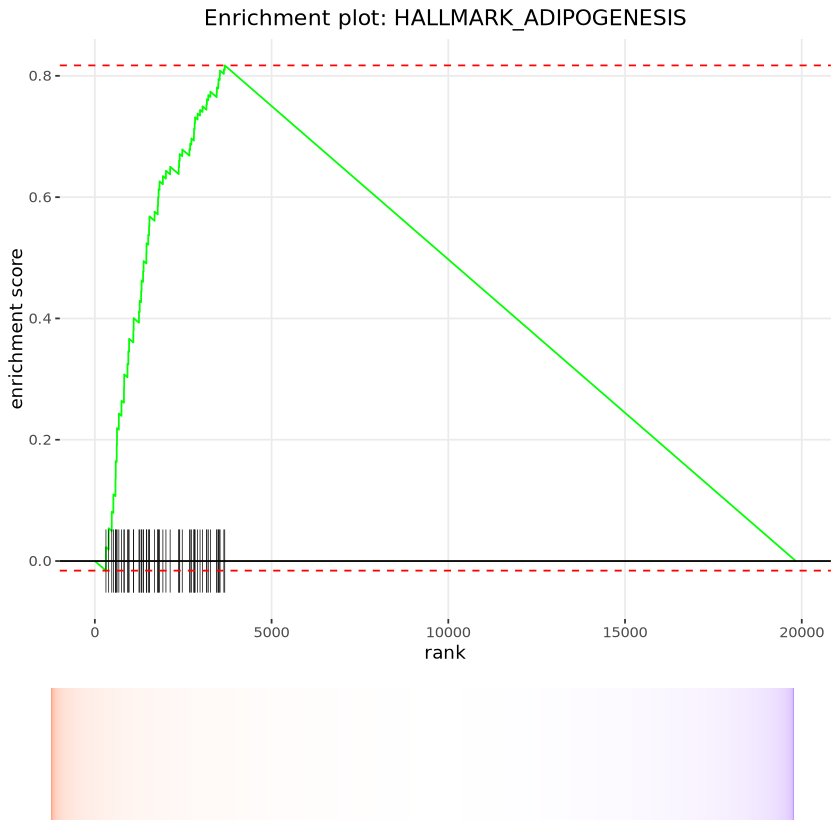

In [31]:
enplot(fgsearesC$RAB5A_vs_EV, "HALLMARK_ADIPOGENESIS", ranksC$RAB5A_vs_EV)

In [29]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




In [ ]:
fgsearesCTidy <- lapply(fgsearesC, function(x) x %>% as_tibble() %>% arrange(desc(NES)))

for (i in names(fgsearesCTidy)) {
  fgsearesCTidy[[i]] <- fgsearesCTidy[[i]] %>% as.data.frame() %>% mutate("Comparison"=i)
}

fgsearesCTidy <- fgsearesCTidy %>%  purrr::reduce(full_join)
fgsearesCTidy$log10_Pvalue <- -log10(fgsearesCTidy$padj)
fgsearesCTidy$log10_Pvalue[fgsearesCTidy$NES < 0] <- fgsearesCTidy$log10_Pvalue[fgsearesCTidy$NES < 0] * -1 

In [ ]:
fgsearesCTidy$pathway <- str_split_fixed(fgsearesCTidy$pathway, "_", 2)[,2]

g <- list()

order <- fgsearesCTidy %>%
    filter(Comparison == "RAB5A_vs_EV") %>% 
    dplyr::select(1) %>%
    pull()

for (i in unique(fgsearesCTidy$Comparison)) {
  g[[i]] = fgsearesCTidy %>%
    filter(Comparison == i) %>%
    ggplot(., aes(reorder(pathway, NES), NES, fill=log10_Pvalue)) +
    scale_x_discrete(limits=order) +
    ylim(c(min(fgsearesCTidy$NES), max(fgsearesCTidy$NES))) +
    geom_bar(stat = "identity")+
    scale_fill_gradient2(low = "blue", high = "red",mid = "grey70") +
    geom_col(aes(colour=padj<0.05)) +
    scale_color_manual(values = c("white", "black"))+
    coord_flip() +
    labs(x="Pathway", y="Normalized Enrichment Score",
         title=paste("Hallmark pathways NES from GSEA", i, sep = " ")) + 
    theme_classic()+
    theme(plot.title = element_text(color="black", size=10, face="bold.italic", hjust = 2),
          axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
          axis.title.x = element_text(face = "bold", color = "black", size = 0),
          axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=9),
          axis.title.y = element_text(face = "bold", color = "black", size = 0),
          legend.text = element_text(face = "bold", color = "black", size = 10),
          legend.position="left",
          panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))
}

for (i in names(g)) {
  ggsave(paste("Hallmark_GSEA_RAB5AvsEV_",i,".png", sep = ""), width=18, height=18, dpi = 330, units = "cm", plot = g[[i]])
}

In [ ]:
fgsearesCTidy_toHT <- fgsearesC

for(i in names(fgsearesCTidy_toHT)) {
    fgsearesCTidy_toHT[[i]] <- fgsearesCTidy_toHT[[i]] #%>% filter(padj < 0.05)
}

fgsearesCTidy_toHT <- fgsearesCTidy_toHT %>% lapply(., function(x) x[, c(1,6)])

for(i in names(fgsearesCTidy_toHT)) {
    names(fgsearesCTidy_toHT[[i]]) <- c("pathway", paste("NES", i, sep = "_"))
}
                                                    
fgsearesCTidy_toHT <- fgsearesCTidy_toHT %>% reduce(., full_join, by = "pathway")
fgsearesCTidy_toHT[is.na(fgsearesCTidy_toHT),]  <- 0 
fgsearesCTidy_toHT$pathway <- str_split_fixed(fgsearesCTidy_toHT$pathway, "_", 2)[,2]                                                   

In [ ]:
test_labels <- fgsearesC

for(i in names(test_labels)) {
    test_labels[[i]] <- test_labels[[i]] #%>% filter(padj < 0.05)
}

test_labels <- test_labels %>% lapply(., function(x) x[, c(1,3)])

for(i in names(test_labels)) {
    names(test_labels[[i]]) <- c("pathway", paste("padj", i, sep = "_"))
}
                                                    
test_labels <- test_labels %>% reduce(., full_join, by = "pathway")
test_labels <- test_labels %>% tibble::column_to_rownames("pathway") %>%  dplyr::select(c("padj_MIX_4_1_vs_EV", "padj_MIX_1_4_vs_EV", "padj_RAB5A_vs_EV")) %>% as.matrix()
test_labels[is.na(test_labels)]  <- 1

pvalue_to_asterisks <- function(p_values) {
  asterisks <- apply(p_values, c(1, 2), function(x) {
    if (x < 0.001) {
      return("***")
    } else if (x < 0.01) {
      return("**")
    } else if (x < 0.05) {
      return("*")
    } else {
      return("") # No significance
    }
  })
  return(asterisks)
}

test_labels <- test_labels %>% pvalue_to_asterisks(.) %>% t()

In [ ]:
crp <- colorRampPalette(c('blue', 'white','red'))
colors = crp(255)

fgsearesCTidy_toHT %>% 
    as.data.frame() %>%
    tibble::column_to_rownames("pathway") %>%
    dplyr::select(c("NES_MIX_4_1_vs_EV", "NES_MIX_1_4_vs_EV", "NES_RAB5A_vs_EV")) %>%
    as.matrix() %>%
    t() %>%
    pheatmap(., fontsize_col = 8, fontsize_number = 12, 
                         display_numbers = test_labels, 
                         number_color = "black",
                         col=colors, border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "none", cluster_rows=F , cluster_cols=T,
                         main = "All_Genes_Pathway", filename = "All_pathway.png",
                         show_rownames = T, legend = TRUE,
                         angle_col = 90, show_colnames = T)

In [ ]:
library(ggvenn)

In [ ]:
DEGs_name_UP <-  lapply(DEGs, function(x)  x %>%
                        filter(log2FoldChange > 0) %>%
                        dplyr::select("Gene_name") %>%
                        pull() %>%
                        unique() %>%
                        na.omit())

DEGs_name_DOWN <-  lapply(DEGs, function(x)  x %>%
                        filter(log2FoldChange < 0) %>%
                        dplyr::select("Gene_name") %>%
                        pull() %>%
                        unique() %>%
                        na.omit())
names(DEGs_name_DOWN) <- c("1:4 EV", "4:1 EV", "RAB5A EV", "1:4 4:1")
names(DEGs_name_UP) <- c("1:4 EV", "4:1 EV", "RAB5A EV", "1:4 4:1")


In [ ]:
ggvenn(DEGs_name_UP, stroke_linetype = 1)
ggsave("Venn_UP.png", dpi = 330, width =20, units = "cm", height = 20)
dev.off()

In [ ]:
ggvenn(DEGs_name_DOWN, stroke_linetype = 1)
ggsave("Venn_DOWN.png", dpi = 330, width =20, units = "cm", height = 20)
dev.off()

In [ ]:
order <- c('EV_1','EV_2','EV_3','MIX_4.1_1','MIX_4.1_2','MIX_4.1_3','MIX_1.4_1','MIX_1.4_2','MIX_1.4_3','RAB5_1','RAB5_2','RAB5_3')

crp <- colorRampPalette(c('blue','white','red'))
colors = crp(255)

rbind(readcounts_norm %>% 
      dplyr::select(c(1:12)) %>% 
      dplyr::filter(rownames(.) %like% "IFI"),
      readcounts_norm %>% 
      dplyr::select(c(1:12)) %>% 
      dplyr::filter(rownames(.) %like% "OASL")) %>%
      dplyr::select(order) %>%
                    pheatmap(., 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         filename = "heatmap_int_1.png",
                         show_rownames = T, labels_row = row.names(.), legend = TRUE,
                         angle_col = 45, show_colnames = F)

In [ ]:
save.image(file = "RNA_seq.RData")

In [ ]:
order <- c('EV_1','EV_2','EV_3','MIX_4.1_1','MIX_4.1_2','MIX_4.1_3','MIX_1.4_1','MIX_1.4_2','MIX_1.4_3','RAB5_1','RAB5_2','RAB5_3')

combine_unique <- function(vector_list) {
  unique_elements <- unique(unlist(vector_list))
  return(unique_elements)
}

gene_int <-  readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    tibble::rownames_to_column(var = "RowName") %>%  # Convert rownames to a column
                    filter(grepl("TLR", RowName)) %>%       # Filter rows starting with "ATF"
                    tibble::column_to_rownames(var = "RowName") %>%
                    rownames(.)

gene_int <- read.table("Methilases.txt", header = F)[,1]

All_DEGs <- combine_unique(lapply(DEGs[c(1:3)], function(x) x %>% dplyr::select("Gene_name") %>% pull()))

readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% All_DEGs) %>%
                    dplyr::filter(rownames(.) %in% gene_int) %>%
                    dplyr::select(order) %>%
                    pheatmap(., 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         filename = "heatmap_int_7.png",
                         show_rownames = T, labels_row = row.names(.), legend = TRUE,
                         angle_col = 45, show_colnames = F)

In [ ]:
gene_int <- c('IFI44','IFIH1','IFIT1','IFIT3','IFI35','IFIT2','IFITM2','IFI27','IFI6','IFI16','IFITM3','IFI44L','IFIT5','IFITM1', 'ISG15','ISG20', 'OASL')

#gene_int <- intersect(gene_int, DEGs %>% lapply(., function(x) x %>% dplyr::select("Gene_name") %>% pull()) %>% Reduce(c,.))
                                                          
my_comparison <- list(c("MIX_4_1", "EV"),
                      c("MIX_4_1", "MIX_1_4"),
                      c("MIX_1_4", "RAB5A"),
                      c("MIX_1_4", "EV"),
                      c("RAB5A", "EV"))
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% gene_int) %>%
                    melt(.) %>%
                    mutate(variable=case_when(variable %in% c("EV_1", "EV_2", "EV_3") ~ "EV", 
                                              variable %in% c("MIX_1.4_1", "MIX_1.4_2", "MIX_1.4_3") ~ "MIX_1_4",
                                              variable %in% c("MIX_4.1_1", "MIX_4.1_2", "MIX_4.1_3") ~ "MIX_4_1",
                                              variable %in% c("RAB5_1", "RAB5_2", "RAB5_3") ~ "RAB5A"))%>%
                    ggplot(., aes(x=variable, y=value, fill=variable)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=1, outlier.size=4, outlier.fill = "black", linewidth = 1) +
                      scale_x_discrete(limits=c("EV", "MIX_4_1", "MIX_1_4", "RAB5A")) +
                      scale_y_continuous(trans='log10') +
                      stat_compare_means(label.y = c(20000, 40000, 60000, 80000, 100000), 
                                         comparisons = my_comparison, 
                                         method = "t.test", 
                                         label = "p.format", 
                                         size = 6)+
                      stat_summary(fun=mean, geom="line", aes(group=1, width=1))  + 
                      stat_summary(fun=mean, geom="point", width = 1) +
                      scale_color_manual(values = mycolors_c) +
                      scale_fill_manual(values=mycolors_c) +
                      ylim(c(0, 1.2e+05)) +
                      theme(plot.title = element_text(color="black", size=15, face="bold.italic"),
                        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=20, hjust =1), 
                        axis.title.x = element_text(face = "bold", color = "black", size = 0),
                        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=20),
                        axis.title.y = element_text(face = "bold", color = "black", size = 25),
                        legend.text = element_text(face = "bold", color = "black", size = 10),
                        legend.position="left",
                        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
                  ggtitle("ISG counts distrubution within condition") +
                  ylab(bquote(~Log[2]~ 'of normalized counts'))
ggsave("plot_ISG_distibution.svg")              
dev.off()

In [ ]:
gene_int <- c('IFI44','IFIH1','IFIT1','IFIT3','IFI35','IFIT2','IFITM2','IFI27','IFI6','IFI16','IFITM3','IFI44L','IFIT5','IFITM1', 'ISG15','ISG20', 'OASL')

gene_int <- intersect(gene_int, DEGs %>% lapply(., function(x) x %>% dplyr::select("Gene_name") %>% pull()) %>% Reduce(c,.))
gene_int

In [ ]:
gene_int <- append(c('IFI44','IFIH1','IFIT1','IFIT3','IFI35','IFIT2','IFITM2','IFI27','IFI6','IFI16','IFITM3','IFI44L','IFIT5','IFITM1'), 
                  readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% c('ISG15','ISG20')) %>% 
                    rownames(.)) %>%
            append(., "OASL") 
my_comparison <- list(c("MIX_4_1", "EV"),
                      c("MIX_4_1", "MIX_1_4"),
                      c("MIX_1_4", "RAB5A"),
                      c("MIX_1_4", "EV"),
                      c("RAB5A", "EV"))
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% gene_int) %>%
                    melt(.) %>%
                    mutate(variable=case_when(variable %in% c("EV_1", "EV_2", "EV_3") ~ "EV", 
                                              variable %in% c("MIX_1.4_1", "MIX_1.4_2", "MIX_1.4_3") ~ "MIX_1_4",
                                              variable %in% c("MIX_4.1_1", "MIX_4.1_2", "MIX_4.1_3") ~ "MIX_4_1",
                                              variable %in% c("RAB5_1", "RAB5_2", "RAB5_3") ~ "RAB5A"))%>%
                    ggplot(., aes(x=variable, y=value, fill=variable)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=1, outlier.size=4, outlier.fill = "black", linewidth = 1) +
                      scale_x_discrete(limits=c("EV", "MIX_4_1", "MIX_1_4", "RAB5A")) +
                      scale_y_continuous(trans='log10') +
                      stat_compare_means(label.y = c(75000),
                                         label.x = c(1),
                                         comparisons = my_comparison, 
                                         method = "anova", 
                                         label = "p.signif", 
                                         size = 6)+
                      stat_summary(fun=mean, geom="line", aes(group=1, width=1))  + 
                      stat_summary(fun=mean, geom="point", width = 1) +
                      scale_color_manual(values = mycolors_c) +
                      scale_fill_manual(values=mycolors_c) +
                      ylim(c(0, 1.2e+05)) +
                      theme(plot.title = element_text(color="black", size=15, face="bold.italic"),
                        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=20, hjust =1), 
                        axis.title.x = element_text(face = "bold", color = "black", size = 0),
                        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=20),
                        axis.title.y = element_text(face = "bold", color = "black", size = 25),
                        legend.text = element_text(face = "bold", color = "black", size = 10),
                        legend.position="left",
                        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
                  ggtitle("ISG counts distrubution within condition") +
                  ylab(bquote(~Log[2]~ 'of normalized counts'))
ggsave("plot_ISG_distibution.png", dpi = 330)              
dev.off()

In [ ]:
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %like% "ISG") %>% 
                    rownames(.)

In [ ]:
ht <- readcounts_norm %>% 
                    dplyr::select(c(1:3, 10:12)) %>% 
                    dplyr::filter(rownames(.) %like% "GJ") %>%
                    dplyr::filter(rowSums(.) > 0) %>% 
                    #dplyr::select(order) %>%
                    pheatmap(., filename = "heatmap_connexins.png",
                         annotation_col = annotation_column,
                         #cutree_rows = 4,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 30, cellheight = 20,
                         scale = "row", cluster_rows=TRUE , cluster_cols=F,
                         show_rownames = T, labels_row = row.names(.), legend = TRUE,
                         angle_col = 45, show_colnames = F)

In [ ]:
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>%
                    names()

In [ ]:
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %like% "IFI") %>%
                    dplyr::select(order) %>%
                    tibble::rownames_to_column("Gene_name") %>%
                    .[match(order_row, rownames(.)),] %>%
                    tail(14) %>%
                    dplyr::select("Gene_name") %>%
                    write.table(., "homer/to_homer_IF.txt", sep = "/t", col.names = F, row.names = F, quote = F)


In [ ]:
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% c("RAB5A", "RAB5B", "RAB5C")) %>%
                    dplyr::select(order) %>%
                    pheatmap(., 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = 20,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         filename = "ht_RAB5.png",
                         show_rownames = T, labels_row = row.names(.), legend = TRUE,
                         angle_col = 45, show_colnames = F)

In [ ]:
tpm3 <- function(counts,len) {
  x <- counts/len
  return(t(t(x)*1e6/colSums(x)))
}

In [ ]:
to_tpm <- annotations %>% 
    group_by(external_gene_name) %>% 
    summarise(transcript_length = max(transcript_length)) %>%
    as.data.frame() %>%
    filter(!is.na(external_gene_name) & external_gene_name != "") %>%
    left_join(raw_anno_aggr %>% tibble::rownames_to_column("external_gene_name"), .) %>%
    tibble::column_to_rownames("external_gene_name")

In [ ]:
tpm <- tpm3(to_tpm[1:12], to_tpm$transcript_length)

In [ ]:
tpm %>% as.data.frame() %>% tibble::rownames_to_column("Gene_name") %>% write.table(., "tmp.txt",quote = F, sep = "\t", col.names = T, row.names = F)

In [ ]:
to_homer_UP <- lapply(DEGs, function(x) x %>% dplyr::filter(padj < 0.05 & log2FoldChange > 0 ) %>% dplyr::select(1))
to_homer_DOWN <- lapply(DEGs, function(x) x %>% dplyr::filter(padj < 0.05 & log2FoldChange < 0 ) %>% dplyr::select(1))

In [ ]:
for(i in names(to_homer_UP)){
    write.table(to_homer_UP[[i]], paste("./homer/UP_", i, "_IF.txt", sep = ""), sep = "/t", col.names = F, row.names = F, quote = F)
    write.table(to_homer_DOWN[[i]], paste("./homer/DOWN_", i, "_IF.txt", sep = ""), sep = "/t", col.names = F, row.names = F, quote = F)
}

In [ ]:
int_list <- list(UP_not_UP_1_4_and_RAB5 = inner_join(res[["MIX_1_4_vs_EV"]] %>% 
           as.data.frame() %>%
           filter(log2FoldChange > 0 & pvalue < 0.05 ) %>%
           dplyr::select(c(2, 6)) %>%
            `colnames<-`(paste(names(.), "MIX_1_4_vs_EV", sep = "_")) %>%
           tibble::rownames_to_column("Gene_name"),
           
           res[["RAB5A_vs_EV"]] %>% 
           as.data.frame() %>%
           filter(log2FoldChange < 0 | padj > 0.05) %>%
           dplyr::select(c(2, 6)) %>%
            `colnames<-`(paste(names(.), "RAB5A_vs_EV", sep = "_")) %>%
           tibble::rownames_to_column("Gene_name"), 
           
           by="Gene_name"),
     
    UP_UP_no_UP_14_and_RAB5_and_41 = inner_join(res[["MIX_1_4_vs_EV"]] %>% 
           as.data.frame() %>%
           filter(log2FoldChange > 0 & pvalue < 0.05 ) %>%
           dplyr::select(c(2, 6)) %>%
            `colnames<-`(paste(names(.), "MIX_1_4_vs_EV", sep = "_")) %>%
           tibble::rownames_to_column("Gene_name"),
           
           res[["RAB5A_vs_EV"]] %>% 
           as.data.frame() %>%
           filter(log2FoldChange > 0 & padj < 0.05) %>%
           dplyr::select(c(2, 6)) %>%
            `colnames<-`(paste(names(.), "RAB5A_vs_EV", sep = "_")) %>%
           tibble::rownames_to_column("Gene_name"), 
           
           by="Gene_name") %>%

inner_join(., 
           res[["MIX_4_1_vs_EV"]] %>% 
           as.data.frame() %>%
           filter(log2FoldChange < 0 | pvalue > 0.05 ) %>%
           dplyr::select(c(2, 6)) %>%
           `colnames<-`(paste(names(.), "MIX_4_1_vs_EV", sep = "_")) %>%
           tibble::rownames_to_column("Gene_name"),
    
           by="Gene_name")) 
write.xlsx(int_list, "int_list.xlsx", overwrite = T)

In [ ]:
GO_int <- list()

for (i in names(int_list)) {
    
gostres <- gost(query = int_list[[i]] %>% dplyr::select("Gene_name") %>% pull(),
                        organism = "hsapiens", 
                        evcodes = TRUE, 
                        significant = TRUE, 
                        correction_method = "fdr",
                        user_threshold = 0.05, sources = "GO:BP") %>%
  .[["result"]] %>%
  dplyr::select(c(3,4,6, 9,11, 16))%>%
  mutate("Comparison"= i, "Perc_of_enrichment"=intersection_size / term_size *100)

GO_int[[i]] <- gostres
    
}

GO_int <- lapply(GO_int, function(x) data.frame(x) %>% mutate(Perc_if_enrichment2 = intersection_size / nrow(x) *100))

In [ ]:
write.xlsx(int_list, "int_list.xlsx", overwrite = T)
write.xlsx(GO_int, "int_list_GO.xlsx", overwrite = T)

In [ ]:
lapply(GO_int, nrow)

for(i in names(GO_int)){
    print(nrow(GO_int[[i]]))
}

In [ ]:
GO_all <- rbind(GO_int$UP_not_UP_1_4_and_RAB5 %>% arrange(-Perc_of_enrichment) %>% head(25), GO_int$UP_UP_no_UP_14_and_RAB5_and_41 %>% arrange(-Perc_of_enrichment) %>% head(25))
#GO_all <- rbind(GO_int$UP_not_UP_1_4_and_RAB5 %>% head(25), GO_int$UP_UP_no_UP_14_and_RAB5_and_41 %>% head(25))
#anti_join(GO_int$UP_not_UP_1_4_and_RAB5, GO_int$UP_UP_no_UP_14_and_RAB5_and_41 , by = "term_id")

ggplot(GO_all, aes(x=Comparison, y=term_name, size=Perc_of_enrichment, color=p_value))+
  geom_point()+
  scale_y_discrete(limits = unique(GO_all$term_name),labels = function(x) str_wrap(unique(GO_all$term_name)))+
  #scale_y_discrete(limits=unique(GO_plot$term_name))+
  #scale_size(range = c(2, 12))+
  scale_color_gradient(low = "Red", high = "grey70") +
  theme(plot.title = element_text(color="black", size=10, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 0),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=8),
        axis.title.y = element_text(face = "bold", color = "black", size = 0),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="left",
        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
  ggtitle("BP with Gprofiler2")
ggsave("GO_int_1.png", dpi = 330, width =20, units = "cm", height = 33)
dev.off()


In [ ]:
source("./homer/read_homer_output.R")

In [ ]:
GO_all <- rbind(subset(GO_int$UP_not_UP_1_4_and_RAB5, !(GO_int$UP_not_UP_1_4_and_RAB5$term_id %in% GO_int$UP_UP_no_UP_14_and_RAB5_and_41$term_id)),
                subset(GO_int$UP_UP_no_UP_14_and_RAB5_and_41, !(GO_int$UP_UP_no_UP_14_and_RAB5_and_41$term_id %in% GO_int$UP_not_UP_1_4_and_RAB5$term_id)) %>% arrange(-p_value)) 
        
GO_all <- rbind(head(GO_all, n = 25), tail(GO_all, n = 25))


ggplot(GO_all, aes(x=Comparison, y=term_name, size=Perc_of_enrichment, color=p_value))+
  geom_point()+
  scale_y_discrete(limits = unique(GO_all$term_name),labels = function(x) str_wrap(unique(GO_all$term_name)))+
  #scale_y_discrete(limits=unique(GO_plot$term_name))+
  #scale_size(range = c(2, 12))+
  scale_color_gradient(low = "Red", high = "grey70") +
  theme(plot.title = element_text(color="black", size=10, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 0),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=8),
        axis.title.y = element_text(face = "bold", color = "black", size = 0),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="left",
        panel.background = element_rect(fill = "white",colour = "white", size = 1, linetype = "solid"))+
  ggtitle("BP with Gprofiler2")
ggsave("GO_int_1_non_common.png", dpi = 330, width =20, units = "cm", height = 25)
dev.off()

In [ ]:
GO_all <- rbind(subset(GO_int$UP_not_UP_1_4_and_RAB5, !(GO_int$UP_not_UP_1_4_and_RAB5$term_id %in% GO_int$UP_UP_no_UP_14_and_RAB5_and_41$term_id)),
                subset(GO_int$UP_UP_no_UP_14_and_RAB5_and_41, !(GO_int$UP_UP_no_UP_14_and_RAB5_and_41$term_id %in% GO_int$UP_not_UP_1_4_and_RAB5$term_id)) %>% arrange(-p_value)) 
        
GO_all <- rbind(head(GO_all, n = 1), tail(GO_all, n = 1))

GO_all

In [ ]:
ggvenn::ggvenn(lapply(GO_int, function(x) x %>% dplyr::select("term_id") %>% pull()), stroke_linetype = 1)


In [ ]:
names(int_list)

In [ ]:
readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% c("RAB5A", "RAB5B", "RAB5C")) %>%
                    #dplyr::select(order) %>%
                    tibble::rownames_to_column("Gene_name") %>%
                    melt() %>%
                    mutate(variable=case_when(variable %in% c("EV_1", "EV_2", "EV_3") ~ "EV", 
                                              variable %in% c("MIX_1.4_1", "MIX_1.4_2", "MIX_1.4_3") ~ "MIX_1_4",
                                              variable %in% c("MIX_4.1_1", "MIX_4.1_2", "MIX_4.1_3") ~ "MIX_4_1",
                                              variable %in% c("RAB5_1", "RAB5_2", "RAB5_3") ~ "RAB5A")) %>%
ggplot(., aes(x=variable, y=log2(value), color=as.factor(variable))) +
    geom_violin(trim=FALSE) +
    scale_color_manual(values = mycolors_c) +
    scale_fill_manual(values=mycolors_c) +
    geom_boxplot(fill = "white", outlier.colour = "black", outlier.shape = 1)+
    #geom_jitter(width = 0.1)+
    facet_wrap(~Gene_name, scale="free") +
    theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 24),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=10),
        axis.title.y = element_text(face = "bold", color = "black", size = 10),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="top",
        panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
  xlab("") + ylab("Log2 of normalized counts")
ggsave("Vio_plot.png", dpi = 330)


In [ ]:
mycolors_c

In [ ]:
read.table("GO_to_plot.txt", header = F)[,1]


In [ ]:
 res[["RAB5A_vs_EV"]] %>% as.data.frame() %>% 
    dplyr::filter(rownames(.) %like% "GJ" & padj < 0.05) %>%
    dplyr::mutate("Condition" = "RAB5A_vs_EV", "log10_Padj" = -log10(padj)) %>%
    tibble::rownames_to_column("Gene_name") %>%
    ggplot(., aes(x=Condition, y = reorder(Gene_name, log2FoldChange), size= log10_Padj, color=log2FoldChange)) +
        geom_point() +
        scale_color_gradient2(low="blue", high="red", mid = "white") +
        theme(plot.title = element_text(color="black", size=26, face="bold.italic"),
        axis.text.x = element_text(angle = 45, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 24),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=10),
        axis.title.y = element_text(face = "bold", color = "black", size = 10),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="top",
        panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid")) +
  xlab("") + ylab("")
ggsave("dot_plot_connexin.png", dpi = 330, height = 10, width = 4, units = "cm")
dev.off()
        
    

In [ ]:
crp <- colorRampPalette(c('blue', 'white','red'))
colors = crp(255)
order <- c('EV_1','EV_2','EV_3','MIX_4.1_1','MIX_4.1_2','MIX_4.1_3','MIX_1.4_1','MIX_1.4_2','MIX_1.4_3','RAB5_1','RAB5_2','RAB5_3')
mat <- readcounts_norm %>% 
                         #dplyr::select(c(1:12)) %>%
                         filter(Gene_name %in% pathways.hallmark$HALLMARK_INTERFERON_GAMMA_RESPONSE) %>%
                         dplyr::select(order)

DEGS_heatmap <- pheatmap(mat, 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = 10,
                         scale = "row", cluster_rows=TRUE ,cluster_cols=F,
                         main = "HALLMARK INTERFERON GAMMA RESPONSE",filename = "HALLMARK_INTERFERON_GAMMA_RESPONSE.png",
                         show_rownames = T, labels_row = row.names(mat), legend = TRUE,
                         angle_col = 45, show_colnames = FALSE)

In [ ]:
crp <- colorRampPalette(c('blue', 'white','red'))
colors = crp(255)
order <- c('EV_1','EV_2','EV_3','MIX_4.1_1','MIX_4.1_2','MIX_4.1_3','MIX_1.4_1','MIX_1.4_2','MIX_1.4_3','RAB5_1','RAB5_2','RAB5_3')

KRT_DEGS <- res[1:3] %>% 
    lapply(., function(x) x %>%
               as.data.frame() %>%
               filter(row.names(x) %like% "KRT" & padj < .05) %>%
               tibble::rownames_to_column("Gene_name") %>% 
                arrange(baseMean) %>%
               dplyr::select(Gene_name) %>%
               pull()) %>%
    unlist()  %>% 
    unique(Reduce(c,.))

readcounts_norm %>% 
                    dplyr::select(c(1:12)) %>% 
                    dplyr::filter(rownames(.) %in% KRT_DEGS) %>%
                    dplyr::select(all_of(order)) %>%
                    pheatmap(., 
                         annotation_col = annotation_column,
                         annotation_colors = ann_colors,
                         col=colors,border_color = "white",
                         cellwidth = 20, cellheight = 10,
                         scale = "column", cluster_rows=T ,cluster_cols=F,
                         filename = "ht_KRT.png",
                         show_rownames = T, labels_row = row.names(.), legend = TRUE,
                         angle_col = 45, show_colnames = F)

In [ ]:
readcounts_norm %>%
    filter(rownames(.) %in% c("RAB5A", "DDR1")) %>% 
    dplyr::select(1:12) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Sample") %>%
    mutate(condition=metadata$condition, rep=metadata$samples)

In [ ]:
to_corr <- readcounts_norm %>%
    filter(rownames(.) %in% c("RAB5A", "DDR1")) %>% 
    dplyr::select(1:12) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Sample") %>%
    mutate(condition=metadata$condition, rep=metadata$samples) %>%
    #filter(condition %in% c("MIX_4_1", "MIX_1_4")) %>%
    as.data.frame() 

# Compute Pearson correlation
correlation <- cor(to_corr$RAB5A, to_corr$DDR1, method = "pearson")

# Print correlation result
print(paste("Pearson correlation coefficient:", round(correlation, 3)))

# Plot correlation
ggplot(to_corr, aes(x=RAB5A, y=DDR1, color=as.factor(condition), shape=rep)) +
  geom_point(size=5) +
  geom_smooth(method="lm", col="red", se=FALSE) +  # Add a trend line
  labs(title=paste("Pearson Correlation: ", round(correlation, 3)),
       x="RAB5A Expression", y="DDR1 Expression") +
  theme(plot.title = element_text(color="black", size=20, face="bold.italic"),
        axis.text.x = element_text(angle = 90, face = "bold", color = "black", size=10, hjust =1), 
        axis.title.x = element_text(face = "bold", color = "black", size = 20),
        axis.text.y = element_text(angle = 0, face = "bold", color = "black", size=10),
        axis.title.y = element_text(face = "bold", color = "black", size = 20),
        legend.text = element_text(face = "bold", color = "black", size = 10),
        legend.position="top",
        panel.background = element_rect(fill = "white",colour = "black", size = 1, linetype = "solid"))
ggsave("corr_all.png")